Importing Essential Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Machine Learning Libraries (Part 1)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

print("Libraries imported successfully.")

Libraries imported successfully.


Loading datasets

In [25]:
# Load the Processed Data
print("Loading processed data...")

# 1. Load Training Data
train_df = pd.read_csv('processed_data/train_processed.csv', index_col=0)
# Split back into X and y
y_train = train_df['price']
X_train = train_df.drop(columns=['price'])

# 2. Load Internal Validation Data
val_df = pd.read_csv('processed_data/val_processed.csv', index_col=0)
# Split back into X and y
y_test = val_df['price']
X_test = val_df.drop(columns=['price'])

# 3. Load External Submission Data (No 'price' column here)
X_submission = pd.read_csv('processed_data/submission_processed.csv', index_col=0)

print(" Data Loaded Successfully.")
print(f"Training Set:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation Set: X={X_test.shape},  y={y_test.shape}")
print(f"Submission Set: X={X_submission.shape}")

Loading processed data...
 Data Loaded Successfully.
Training Set:   X=(12967, 16), y=(12967,)
Validation Set: X=(3242, 16),  y=(3242,)
Submission Set: X=(5404, 20)


Training Random Forest Model (Part 1)

In [26]:
print("--- PART 1: TABULAR BASELINE (Random Forest) ---")

# 1. Initialize
rf_model = RandomForestRegressor(n_estimators=100,max_depth=None,bootstrap=True,oob_score=True,random_state=42)

# 2. Train
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_rf = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(" Random Forest Results:")
print("R² Score: ",rf_r2)
print("RMSE: ",rf_rmse)

--- PART 1: TABULAR BASELINE (Random Forest) ---
Training Random Forest...
 Random Forest Results:
R² Score:  0.8609411137147176
RMSE:  132099.60783401178


Block 1: Defines the MultimodalDataGenerator to handle image and tabular data loading ( Custom Data Generator Class)

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

class MultimodalDataGenerator(Sequence):
    """
    Custom Data Generator for Hybrid AI.
    Loads data in batches (e.g., 32 at a time) to prevent RAM crashes.
    Inputs: 
        1. House Images (Satellite view)
        2. Tabular Data (Bedrooms, Sqft, etc.)
    Output:
        1. Price (Target)
    """
    def __init__(self, df, x_col, y_col, image_dir, batch_size=32, target_size=(224, 224), shuffle=True):
        self.df = df.copy()         # Work on a copy to avoid modifying original data
        self.x_col = x_col          # Column name for House ID (index)
        self.y_col = y_col          # Column name for Price (Target)
        self.image_dir = image_dir  # Path to 'house_images' folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        
        # Create a list of indices (0 to N) to track rows
        self.indices = np.arange(len(self.df))
        
        # Shuffle immediately upon starting
        self.on_epoch_end()

    def __len__(self):
        """Calculates the number of batches per epoch."""
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # 1. Select the indices for this batch (e.g., rows 0 to 32)
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # 2. Find the House IDs for these rows
        batch_ids = [self.df.index[k] for k in indices]

        # 3. Generate data
        X, y = self.__data_generation(batch_ids, indices)
        return X, y

    def on_epoch_end(self):
        """Shuffles data after every epoch so the model doesn't memorize order."""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_ids, batch_indices):
        """Loads the images and numbers for the specific batch."""
        
        # --- PART A: LOAD IMAGES ---
        images = []
        for house_id in batch_ids:
            img_path = os.path.join(self.image_dir, f"{house_id}.jpg")
            
            # Safety Check: If image didn't download, use a black placeholder
            if os.path.exists(img_path):
                try:
                    img = load_img(img_path, target_size=self.target_size)
                    img = img_to_array(img)
                    img = img / 255.0  # Normalize (0-255 -> 0-1)
                except:
                    # If image is corrupt
                    img = np.zeros((self.target_size[0], self.target_size[1], 3))
            else:
                # If image is missing
                img = np.zeros((self.target_size[0], self.target_size[1], 3))
            
            images.append(img)
        
        images = np.array(images)

        # --- PART B: LOAD TABULAR DATA ---
        # We drop the 'price' column if it exists, because that is the Target (y), not Input (X)
        if self.y_col and self.y_col in self.df.columns:
            tabular = self.df.iloc[batch_indices].drop(columns=[self.y_col]).values
        else:
            tabular = self.df.iloc[batch_indices].values
        
        # --- PART C: LOAD TARGET (PRICE) ---
        if self.y_col and self.y_col in self.df.columns:
            y = self.df.iloc[batch_indices][self.y_col].values
            return (images, tabular), y  # Return (Inputs, Output)
        else:
            return (images, tabular)     # Return (Inputs Only - for Prediction)

Block 2:Sets up train_gen and val_gen with the correct batch size and image folders(Initialize Generators)

In [32]:
# --- BLOCK 2: INITIALIZE GENERATORS ---

# 1. Configuration
IMAGE_FOLDER = 'house_images'  # Must match the folder name where images are downloading
BATCH_SIZE = 32                # Process 32 houses at a time
IMAGE_SIZE = (224, 224)        # The standard size that AI models prefer

print("Preparing Data Generators...")

# 2. Re-combine X and y for the Generator
# The generator expects one single dataframe so it can shuffle X and y together securely.
train_full = pd.concat([X_train, y_train], axis=1)
val_full = pd.concat([X_test, y_test], axis=1)

# 3. Create the Training Generator
train_gen = MultimodalDataGenerator(
    df=train_full,
    x_col='id',       # Uses the Index (House ID) to find the image
    y_col='price',    # The target value we are predicting
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=True      # True: Mixes up data so the model learns better
)

# 4. Create the Validation Generator
val_gen = MultimodalDataGenerator(
    df=val_full,
    x_col='id',
    y_col='price',
    image_dir=IMAGE_FOLDER,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    shuffle=False     # False: Keep order stable for accurate scoring
)

print(f" Generators Ready!")
print(f" - Training Batches per Epoch: {len(train_gen)}")
print(f" - Validation Batches per Epoch: {len(val_gen)}")

Preparing Data Generators...
 Generators Ready!
 - Training Batches per Epoch: 405
 - Validation Batches per Epoch: 101


Block 3:Constructs the model architecture using EfficientNetB0 for images and Dense layers for tabular data(Build Hybrid Neural Network)

In [33]:
# --- BLOCK 3: BUILD THE HYBRID MODEL ---
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_hybrid_model(tabular_shape):
    # --- BRANCH 1: IMAGE PROCESSING (The Visual Eye) ---
    # We use EfficientNetB0, pre-trained on ImageNet data
    # include_top=False means we cut off the final classification layer (we don't need to classify cats/dogs)
    print("Downloading EfficientNetB0 weights...")
    base_cnn = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model so we don't destroy its pre-learned patterns
    base_cnn.trainable = False
    
    # Input layer for images
    image_input = Input(shape=(224, 224, 3), name='image_input')
    
    # Pass images through the CNN
    x_img = base_cnn(image_input)
    x_img = GlobalAveragePooling2D()(x_img) # Condenses the image features into a vector
    
    # --- BRANCH 2: TABULAR PROCESSING (The Logical Eye) ---
    # Input layer for numbers (bedrooms, sqft, etc.)
    tabular_input = Input(shape=(tabular_shape,), name='tabular_input')
    
    # A simple neural network for the numbers
    x_tab = Dense(64, activation='relu')(tabular_input)
    x_tab = Dense(32, activation='relu')(x_tab)
    
    # --- COMBINE BOTH BRANCHES ---
    # Glue the Visual info and Logical info together
    combined = concatenate([x_img, x_tab])
    
    # --- FINAL PREDICTION LAYERS ---
    # The "Head" of the network that makes the decision
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.2)(x) # Dropout helps prevent overfitting
    x = Dense(64, activation='relu')(x)
    
    # Output Layer: 1 single number (The Price)
    # linear activation is standard for Regression
    output = Dense(1, activation='linear', name='price_output')(x)
    
    # Assemble the full model
    model = Model(inputs=[image_input, tabular_input], outputs=output)
    
    # Compile: We use Adam optimizer and Mean Squared Error (MSE) loss
    # Learning rate 0.001 is a safe starting point
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    
    return model

# Initialize the Model
# X_train.shape[1] automatically detects how many columns you have (bedrooms, sqft, etc.)
print("Building Model...")
hybrid_model = build_hybrid_model(tabular_shape=X_train.shape[1])

print("Model Architecture Built Successfully!")
hybrid_model.summary()

Building Model...
Model Architecture Built Successfully!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      1,088 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1312)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │    168,064 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         65 │ dense_15[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,229,124 (16.13 MB)

 Trainable params: 179,553 (701.38 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Block 4: Runs the training loop with Callbacks for Checkpointing, Early Stopping, and Learning Rate Reduction(Train the model)

In [34]:
# ----Block 4---- 
#The training loop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Training Configuration ---

# 1. Checkpoint: Save the model only when validation accuracy improves
checkpoint = ModelCheckpoint(
    filepath='best_hybrid_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# 2. Early Stopping: Halt training if validation loss stops improving (prevents overfitting)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 3. Learning Rate Scheduler: Slow down learning rate if loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# --- Execute Training ---
print("Starting training process...")

history = hybrid_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

print("Training finished.")

Starting training process...


c:\Users\navya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 183902152173.0370 - mae: 268670.5169

c:\Users\navya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from None to 32782356480.00000, saving model to best_hybrid_model.keras

Epoch 1: finished saving model to best_hybrid_model.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - loss: 82558976000.0000 - mae: 170518.4062 - val_loss: 32782356480.0000 - val_mae: 118072.1016 - learning_rate: 0.0100
Epoch 2/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - loss: 37235802147.3975 - mae: 119612.1144
Epoch 2: val_loss improved from 32782356480.00000 to 30211053568.00000, saving model to best_hybrid_model.keras

Epoch 2: finished saving model to best_hybrid_model.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 363s 897ms/step - loss: 38319763456.0000 - mae: 119198.2109 - val_loss: 30211053568.0000 - val_mae: 107545.1875 - learning_rate: 0.0100
Epoch 3/20
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - loss: 36049124931.0025 - mae: 115416.2802
Epoch 3: val_loss did not improve from 30211053568.00000
405/405 ━━━━━━━━━━━━━━━━━━━━ 377s 932ms/step - loss: 36055240704.0000 - mae: 116353.5000 -

Block 5: Plots the Training vs. Validation Loss to check for overfitting (Visualize Training History)

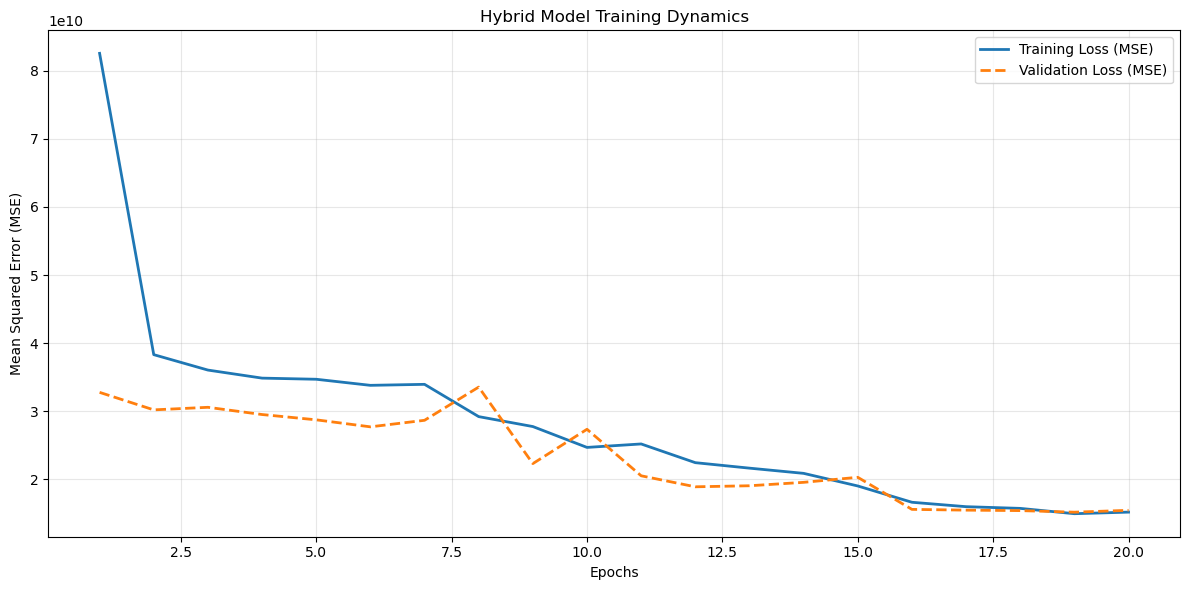

In [35]:
#------Block 5-----
# Visualization

def plot_training_history(history):
    """
    Plots the training and validation loss curves to evaluate model performance.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, label='Training Loss (MSE)', linewidth=2)
    plt.plot(epochs, val_loss, label='Validation Loss (MSE)', linestyle='--', linewidth=2)
    
    plt.title('Hybrid Model Training Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the results
if 'history' in locals():
    plot_training_history(history)

Block 6: Loads the best saved model, predicts on the validation set, calculates R², and plots the Actual vs. Predicted graph (Model Evaluation)

Loading best performing model...
Generating predictions on validation set...
101/101 ━━━━━━━━━━━━━━━━━━━━ 68s 646ms/step

--- FINAL HYBRID MODEL PERFORMANCE ---
R² Score: 0.8791
RMSE:     123,249.70


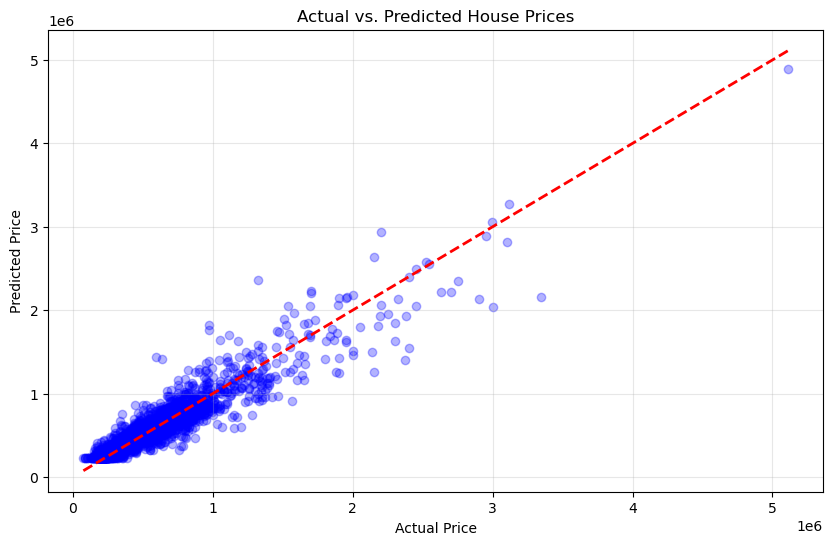

In [36]:
# --- BLOCK 6: MODEL EVALUATION ---
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score, mean_squared_error

print("Loading best performing model...")
# Load the model state with the lowest validation loss from training
best_model = load_model('best_hybrid_model.keras')

# 1. Generate Predictions
# Note: We use the validation generator to ensure data preprocessing matches training exactly
print("Generating predictions on validation set...")
val_predictions = best_model.predict(val_gen, verbose=1).flatten()

# 2. Align Ground Truth Data
# The generator processes data in full batches. We must align the actual labels 
# to match the number of predictions generated (dropping any final partial batch).
y_val_actual = val_gen.df[val_gen.y_col].values[:len(val_predictions)]

# 3. Calculate Metrics
r2 = r2_score(y_val_actual, val_predictions)
rmse = np.sqrt(mean_squared_error(y_val_actual, val_predictions))

print("\n--- FINAL HYBRID MODEL PERFORMANCE ---")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     {rmse:,.2f}")

# 4. Visualization: Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_val_actual, val_predictions, alpha=0.3, color='blue')
plt.plot([y_val_actual.min(), y_val_actual.max()], [y_val_actual.min(), y_val_actual.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True, alpha=0.3)
plt.show()